In [3]:

%matplotlib inline
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os as os
import sys
import warnings
import time
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')
np.random.seed(2)
from IPython.display import Image

# From Matplotlib
from matplotlib.colors import ListedColormap

# From Scikit Learn
from sklearn import preprocessing, decomposition, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from astropy.table import Table, Column
from sklearn.preprocessing import LabelEncoder
import itertools

# Set DEBUG = True to produce debug results
DEBUG = False

In [4]:

%time digit_train = pd.read_excel("sample_data/DATA.xlsx")
%time digit_test = pd.read_excel("sample_data/submit.xlsx")

CPU times: user 8.43 s, sys: 54.8 ms, total: 8.49 s
Wall time: 8.49 s
CPU times: user 2.9 s, sys: 17.2 ms, total: 2.91 s
Wall time: 2.92 s


In [5]:
digit_train.describe()

,idData,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,500.500000,4.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132000,...,3.558000,2.184000,1.241000,1.45000,1.107000,0.37700,0.045000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031000,0.177000,0.692000,0.972000,0.752000,0.579000,0.89300,0.459000,0.14300,0.051000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,288.819436,2.873719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.174207,...,25.993466,20.612545,14.374406,17.28862,15.095477,8.47081,1.423025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.980306,4.016192,11.471824,13.854066,12.340696,8.504121,14.46232,8.382875,3.93523,1.612762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,250.750000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,500.500000,4.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,750.250000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1000.000000,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [6]:
digit_test.describe()

,idData,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,500.000000,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.000000,500.000000,500.000000,500.0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.0,500.0,500.0,500.0,500.0,500.0,500.0
mean,250.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.420000,5.700000,4.750000,2.632000,0.458000,0.010000,0.374000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094000,0.506000,0.112000,0.0,0.226000,0.518000,0.702000,0.988000,0.878000,0.246000,0.32400,0.522000,0.932000,0.652000,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,144.481833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.990628,33.629509,30.769612,23.568613,6.887024,0.223607,8.362894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.101904,11.314504,2.504396,0.0,5.053514,10.173528,10.972785,13.120371,13.234403,3.914605,7.24486,8.255533,14.775792,11.739272,0.894427,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,125.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,250.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,375.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [7]:
# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
digit_train = digit_train.dropna(axis = 0, how = 'all')
digit_test = digit_test.dropna(axis = 0, how = 'all')
if DEBUG:
    #Dimensions of dataset
    print("Shape of Data", digit_train.shape)
    print("Shape of Data", digit_test.shape)
    #Colum names
    print("Colums Names", digit_train.columns)
    print("Colums Names", digit_test.columns)
    #See bottol few rows of dataset
    print(digit_train.tail())

In [8]:
# designate target variable name
targetName = 'label'
targetSeries = digit_train[targetName]
#remove target from current location and insert in collum 0
del digit_train[targetName]
digit_train.insert(0, targetName, targetSeries)
#reprint dataframe and see target is in position 0
digit_train.head()

,label,idData,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
digit_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Columns: 786 entries, label to pixel783
dtypes: int64(786)
memory usage: 6.0 MB


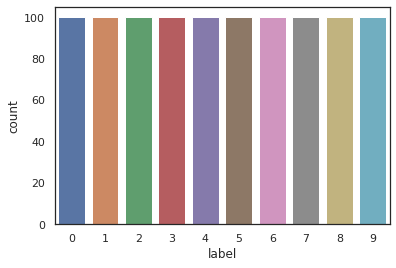

In [10]:
sns.countplot(digit_train['label'])

In [11]:
print(digit_train['label'].describe())

count    1000.000000
mean        4.500000
std         2.873719
min         0.000000
25%         2.000000
50%         4.500000
75%         7.000000
max         9.000000
Name: label, dtype: float64


In [12]:
if DEBUG:
    print(digit_train.dtypes)

In [13]:
digit_train['label'] = digit_train['label'].astype(str)
if DEBUG:
    print(digit_train['label'].describe())

In [14]:
features_train = digit_train.iloc[:,1:]
target_train = digit_train.iloc[:,0]
features_test = digit_test.iloc[:,0:]

In [15]:
# pixel values are gray scale between 0 and 255
# normalize inputs from 0-255 to 0-1
features_train = features_train/255.0
features_test = features_test/255.0

In [16]:
if DEBUG:
    print(features_train)

In [17]:
start_time = time.perf_counter()
train_results = []
test_results = []
# search for an optimal value of k for KNN MOdel
k_range = list(range(1,5))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm='ball_tree', leaf_size=40, weights='uniform')
    scores = cross_val_score(knn, features_train, target_train, cv=10, scoring='accuracy', n_jobs=-1)
    k_scores.append(scores.mean())
if DEBUG:
    print(k_scores) 
print(time.perf_counter() - start_time, "seconds")

4.530539218999991 seconds


In [18]:
if DEBUG:
    scores = pd.DataFrame(k_scores)
    print(scores)

Text(0.5, 1.0, 'KNN Model for Accuracy')

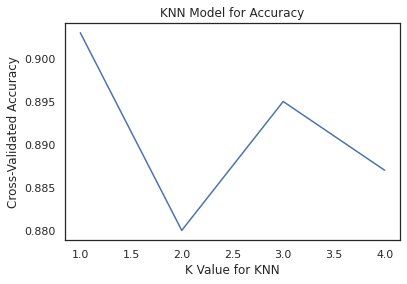

In [19]:
# plot the value of K (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('K Value for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Model for Accuracy')

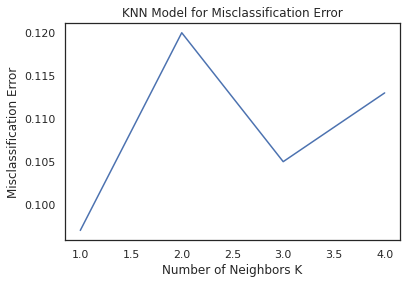

In [20]:
# changing to misclassification error
MSE = [1 - x for x in k_scores]

# determining best k
optimal_k = k_range[MSE.index(min(MSE))]

# plot misclassification error vs k
plt.plot(k_range, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.title('KNN Model for Misclassification Error')
plt.show()

In [21]:
print("The optimal number of neighbors is %d." % optimal_k)

The optimal number of neighbors is 1.


In [22]:
start_time = time.perf_counter()
#KNN train model. Call up my model and name it clf_knn
clf_knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1, algorithm='ball_tree', leaf_size=40, weights='uniform')
#Call up the model to see the parameters you can tune (and their default setting)
print(clf_knn)
#Fit clf to the training data
clf_knn = clf_knn.fit(features_train, target_train)
#Predict clf_knn model again test data
target_predicted_knn = clf_knn.predict(features_test)
print(time.perf_counter() - start_time, "seconds")

KNeighborsClassifier(algorithm='ball_tree', leaf_size=40, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')
0.35888587400000915 seconds


In [23]:
start_time = time.perf_counter()
#verify KNN with Cross Validation
scores_knn = cross_val_score(clf_knn, features_train, target_train, cv=10, scoring='accuracy', n_jobs=-1)
print("Cross Validation Score for each K",scores_knn)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_knn.mean(), scores_knn.std() * 2))
print(time.perf_counter() - start_time, "seconds")

Cross Validation Score for each K [0.89 0.88 0.88 0.92 0.86 0.87 0.92 0.9  0.9  0.93]
Accuracy: 0.89 (+/- 0.04)
0.8806126640000116 seconds


In [24]:
digit_test['iddata'] = pd.Series(target_predicted_knn)
digit_test['klasifikasi'] = pd.Series(range(1,28001))

In [25]:
start_time = time.perf_counter()
akurasi = (scores_knn.mean() * 100)

In [26]:
digit_test['iddata'] = pd.Series(target_predicted_knn)
digit_test['klasifikasi'] = pd.Series(range(1,28001))
digit_test['akurasi'] = pd.Series(akurasi)


In [27]:
digit_test.to_excel('submission_knn.xlsx', columns=["iddata","klasifikasi"], index=False)

In [28]:
digit_test.to_excel('latih.xlsx', columns=["iddata","klasifikasi","akurasi"], index=False)